In [1]:
#%%
# Section of the Python code where we import all dependencies on third party Python modules/libaries or our own
# libraries (exposed C++ code to Python, i.e. darts.engines && darts.physics)
from model_deadoil import ModelDA
import numpy as np
import meshio
from darts.engines import *

import concurrent.futures
import math
import os
import re
import shutil
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import pandas as pd
import scipy.stats as stats

In [3]:
#%%
#function to get an angle and output apertures 

def aperture_vec(rotation):
    def calc_aperture(sigma_n):
        JRC = 7.225
        JCS = 17.5
        e_0 = 0.15
        v_m = -0.1032 - 0.0074 * JRC + 1.135 * (JCS / e_0) ** -0.251
        K_ni = -7.15 + 1.75 * JRC + 0.02 * JCS / e_0
        return e_0 - (1 / v_m + K_ni / sigma_n) ** -1


    DIR = 'mesh_files'
    scale = 15
    mesh_file = os.path.join(DIR, 'mesh_{:}_real_6.msh'.format(scale))
    mesh_data = meshio.read(mesh_file)
    num_frac = mesh_data.cells[0].data.shape[0]
    act_frac_sys = np.zeros((num_frac, 4))

    for ii in range(num_frac):
        ith_line = mesh_data.points[mesh_data.cells[0].data[ii][:2]]
        act_frac_sys[ii, :2] = ith_line[0, :2]
        act_frac_sys[ii, 2:] = ith_line[1, :2]

    # Plot to check if it worked:
    #plt.figure()
    #plt.plot(np.array([act_frac_sys[:, 0], act_frac_sys[:, 2]]),
    #         np.array([act_frac_sys[:, 1], act_frac_sys[:, 3]]), color='black')
    #plt.show()

    epsilon = 1e-4
    dx = act_frac_sys[:, 0] - act_frac_sys[:, 2] + epsilon * np.random.rand(num_frac)
    dy = act_frac_sys[:, 1] - act_frac_sys[:, 3] + epsilon * np.random.rand(num_frac)
    #rotation = 0
    angles = np.arctan(dy / dx) * 180 / np.pi + rotation + epsilon * np.random.rand(num_frac)
    sigma_H = 5
    sigma_h = 1
    sigma_n = (sigma_H + sigma_h) / 2 + (sigma_H + sigma_h) / 2 * np.cos(angles * np.pi / 180 * 2)
    factor_aper = 2.5
    fracture_aper = calc_aperture(sigma_n) * 1e-3 * factor_aper
    fracture_aper[fracture_aper < 1e-9] = 1e-9
    fracture_aper[fracture_aper > 0.15 * 1e-3 * factor_aper] = 0.15 * 1e-3 * factor_aper

    m_to_mm = 1e3
    min_aper = 1e-9 * m_to_mm
    max_aper = 0.15 * 1e-3 * factor_aper * m_to_mm
    fracs = fracture_aper * m_to_mm
    fracs[fracs < min_aper] = min_aper
    fracs[fracs > max_aper] = max_aper
    #norm = colors.Normalize(min_aper, max_aper)
    #colors_aper = cm.viridis(norm(fracs))
    #cutoff_value = min_aper

    #comement lines below
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=400, facecolor='w', edgecolor='k')
    #for ii in range(len(fracs)):
    #    if fracs[ii] >= cutoff_value:
    #        ax.plot(np.array([act_frac_sys[ii, 0], act_frac_sys[ii, 2]]),
    #                np.array([act_frac_sys[ii, 1], act_frac_sys[ii, 3]]),
    #                 color=colors_aper[ii, :-1])

    #ax.axis('equal')

    #for tick in ax.xaxis.get_major_ticks():
    #    tick.label.set_fontsize(14)
    #for tick in ax.yaxis.get_major_ticks():
    #    tick.label.set_fontsize(14)

    #sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    #sm._A = []
    #cbar = plt.colorbar(sm)
    #cbar.set_label(r'Aperture, $a$ [mm]')

    #plt.tight_layout()
    #plt.savefig("variable_aperture_base_case_scale_{:}.pdf".format(scale))
    #plt.show()
    return np.array(fracture_aper)



In [4]:
aperture_vec(30).shape

(1370,)

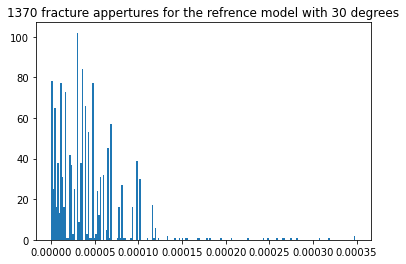

In [32]:
#%%
#First we define the model that will be used as refference with a 8138 distribution of fracture appertures - np.array with 8138 elements distributed from a uniform distribution
angle_ref = 30 #degress
NFractures = aperture_vec(angle_ref).shape[0]
frac_aper_het =  np.zeros(NFractures)
frac_aper_het = aperture_vec(angle_ref) #np.clip(np.random.normal(1e-3, 0.1*(1e-3), NFractures),0.0005,0.0015)
plt.hist(frac_aper_het, bins=200)
plt.title(f'{aperture_vec(angle_ref).shape[0]} fracture appertures for the refrence model with {angle_ref} degrees')
plt.show()

In [8]:
#%%
#First we define the model that will be used as refference frac_aper = = 1e-3 (base case produced by Stephan)
# 
m_true = ModelDA(frac_aper =aperture_vec(30))
time_range = np.arange(0,1000, 10)+1
# After constructing the model, the simulator needs to be initialized. The init() class method is called, which is
# inherited (https://www.python-course.eu/python3_inheritance.php) from the parent class DartsModel (found in
# darts/models/darts_model.py (NOTE: This is not the same as the__init__(self, **) method which each class (should)
# have).

m_true.init()
# Specify some other time-related properties (NOTE: all time parameters are in [days])
m_true.params.max_ts = 1  # Adjust the maximum time-step as desired (this is overwriting the max_ts specified in model.py)
m_true.run(time_range[-1])


darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8



In [9]:
import pandas as pd
time_data = pd.DataFrame.from_dict(m_true.physics.engine.time_data)
writer = pd.ExcelWriter('m_true_time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()



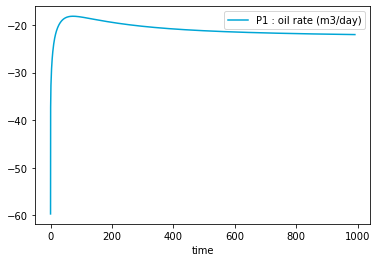

In [10]:
from darts.tools.plot_darts import *
prod = m_true.reservoir.wells[1]
inj =   m_true.reservoir.wells[0]
ax2 = plot_oil_rate_darts(prod.name, time_data)


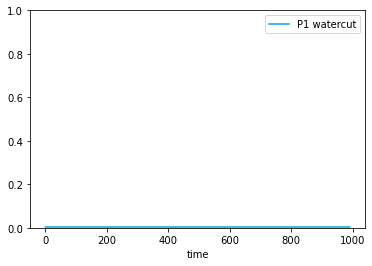

In [11]:
ax3 = plot_watercut_darts(prod.name, time_data)

In [12]:
# data colums
columnsNameList = ['P1 : oil rate (m3/day)']
#create a function that store the mean of the data in a array X of Y elements that are between two values a and b
def media_function(time_range, time_data,columnsNameList):
    media =[]
    i= 1
    while i<=(len(time_range)-1):
        s=[]
        for j,tempo in enumerate(time_data['time']):
                if time_range[i-1]<time_data['time'][j]<=time_range[i]:
                    s.append(time_data[columnsNameList[0]][j])
                    np.mean(s)
        media.append(np.mean(s))
        i=i+1
    return media

In [13]:
##Create hard data from true model
columnsNameList = ['P1 : oil rate (m3/day)']
#obsData= -1*np.array(time_data['P1 : oil rate (m3/day)'])
obsValues = -1*np.array(media_function(time_range, time_data, columnsNameList))
dObs = obsValues.T.flatten()
dTime= np.array(time_range)

CeDiag =np.array(0.001*dObs[:]) #diagonal of the covariance matrix of observed data %1 of the oil rate
NTimesteps=len(dTime)
NWells=1
wells = ['P1']
wellDObs = np.repeat(wells, NTimesteps) #Configure the wells list


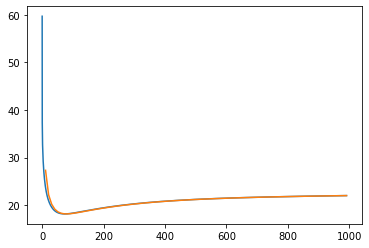

In [14]:
plt.plot(time_data['time'],-1*time_data['P1 : oil rate (m3/day)'])
plt.plot(time_range[1:], dObs)
plt.show()



In [33]:
#create a function to run ensemble simulations based on the prior ensemble
def RunModels(destDir, MScalar):
    for i, mMScalar in enumerate(MScalar.T):
        # create a model object
        m = ModelDA(frac_aper = aperture_vec(math.degrees(mMScalar)));
        # initialize the model
        m.init();
        m.params.max_ts = 10
        # run the model
        start = time.time()
        m.run(time_range[-1]);
        # get the data
        time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
         # write timedata to output file
        time_data.to_pickle(f'{destDir}\\data_model'+str(i)+'.pkl')  
        end = time.time()
        print(f'Elapsed time: {end - start} for model {str(i)}')

In [36]:
#Read the result from the model
def ReadModels(destDir, columnsNameList, Nd, Ne):
    D = np.empty([Nd, Ne])
    for i in range(Ne):
        dataSet = pd.read_pickle(f'{destDir}\\data_model'+str(i)+'.pkl') 
        model_value=np.array([])
        for name in columnsNameList:
            model_value = -1*np.array(media_function(time_range, dataSet, columnsNameList))
        
        d_models = model_value.T.flatten()    
           
        D[:,i] = d_models 

    return D

In [37]:
#functions to run ES-MDA
# Finds the truncation number - if using SVD
def FindTruncationNumber(Sigma, csi):
    temp = 0
    i = 0
    svSum = np.sum(Sigma)
    stopValue = svSum * csi
    for sv in np.nditer(Sigma):
        if (temp >= stopValue):
            break
        temp += sv
        i += 1
    return i

#Series of matriz treatments to make the process less memory consuming  - 
# see  Evensen, G., The Ensemble Kalman Filter: Theoretical Formulation and Practical Implementation, Ocean Dynamics (2003)
def CentralizeMatrix(M):
    meanMatrix = np.mean(M, axis=0)
    return M - meanMatrix


def UpdateModelLocalized(M, Psi, R, DobsD):
    DeltaM = CentralizeMatrix(M)

    K = DeltaM @ Psi
    Kloc = R * K ## Kalman gain with localization 
    return M + Kloc @ DobsD 

def UpdateModel(M, Psi, DobsD):
    DeltaM = CentralizeMatrix(M)

    X10 = Psi @ DobsD
    return M + DeltaM @ X10

In [38]:
#%%
#Calculate objetive function
def calcDataMismatchObjectiveFunction(dObs, D, CeInv):
    Ne = D.shape[1]
    Nd = D.shape[0]

    Od = np.empty(Ne)
    for i in range(Ne):
        dObsD = dObs - D[:,i].reshape(Nd,1)
        Od[i] = (dObsD.T) @ (CeInv[:,np.newaxis] * dObsD)/2
    return Od

# Replaces the pattern with the value in array cosrresponding its position.
# Only 1 group per line for now...
def ReplacePattern(matchobj, array):
    return f'{array[int(matchobj.group(1))]:.2f}'

In [39]:
#Building the prior ensemble based only on frac_aper 
# problem dimensions
#Ni = m_true.nx
#Nj = m_true.ny
NGrid = 0 # Ni * Nj
NScalar = 1 #we just considering one scalar as the parameter in the problem
Nm = NGrid + NScalar
Nd = len(dObs)* 1 #  timesteps * 1 well data
Ne = 3
NTimesteps = len(dTime)
NWells = 1 #we just considering one well

# svd truncation parameter for SVD 
csi = 0.99

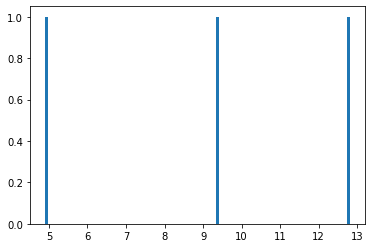

'c:\\Users\\bgy3\\OneDrive - PETROBRAS\\Documents\\PhD\\08.Simple-Fracture-Model-DARTS\\DA-DARTS-Naturally-Fractured-Reservoir-1'

In [52]:
#%%
#Generate the prior ensemble of scalar parameters
angle_ensemble = np.clip(np.random.normal(30/math.pi, 10/math.pi, Ne),0/math.pi,90/math.pi)
Em_frac_aper=[]
for i, angle in enumerate(angle_ensemble):
    Em_frac_aper.append(aperture_vec(math.degrees(angle)))



# data colums
columnsNameList = ['P1 : oil rate (m3/day)']

MScalarPrior = angle_ensemble
#print MScalarPrioir histogram

plt.hist(MScalarPrior, bins=100)
plt.show()
#%%
curDir = os.getcwd()
srcDir =  f'{curDir}'
srcDir

In [54]:
convert = lambda x : math.degrees(x)
MScalarPrior = list(map(convert, MScalarPrior))
MScalarPrior

[30650.013489368677, 16112.01649528033, 42039.902293569845]

In [23]:
# %%
#Run ES-MDA
SDiag = np.sqrt(CeDiag)
SInvDiag = np.power(SDiag, -1)

INd = np.eye(Nd)

MGrid = [] #not considering grid parameters
MScalar = MScalarPrior

alphas = [4., 4., 4., 4.]
l = 0
for alpha in alphas:
    # 2. Forecast

    # Generates the perturbed observations 
    z = np.random.normal(size=(Nd,Ne))
    DPObs = dObs[:,np.newaxis] + math.sqrt(alpha) * CeDiag[:,np.newaxis] * z

    # Run the simulations g(M) 
    destDir = f'{curDir}\\simulations_deadoil_angle\\it{l}'
    RunModels(destDir, MScalar)
    D = ReadModels(destDir, columnsNameList, Nd, Ne)
    if (l == 0):
        DPrior = D

    DobsD = DPObs - D

    # 4. Analysis
    # 4.1 Invert matrix C

    # Calculates DeltaD (12.5)
    meanMatrix = np.mean(D, axis=1)
    DeltaD = D - meanMatrix[:,np.newaxis]

    # Calculates CHat (12.10)
    CHat = SInvDiag[:,np.newaxis] * ( DeltaD @ DeltaD.T ) * SInvDiag[np.newaxis,:] + alpha * (Ne - 1) * INd

    # Calculates Gamma and X (12.18)
    U, SigmaDiag, Vt = np.linalg.svd(CHat)
    Nr = FindTruncationNumber(SigmaDiag, csi)

    GammaDiag = np.power(SigmaDiag[0:Nr], -1)
    X = SInvDiag[:,np.newaxis] * U[:,0:Nr]

    # Calculates M^a (12.21)
    X1 = GammaDiag[:,np.newaxis] * X.T
    X8 = DeltaD.T @ X
    X9 = X8 @ X1
    
    # subpart: for grid, use localization
    #MGrid = UpdateModelLocalized(MGrid, X9, Rmd, DobsD)

    # subpart: for scalars, don't use localization
    
    MScalar = UpdateModel(MScalar, X9, DobsD)
    MScalar[:] = np.clip(MScalar[:], 0,90)
    for i, mMScalar in enumerate(MScalar):
     print(i)
     print(mMScalar)
   
    l += 1
#%%
#MGridPost = MGrid
MScalarPost = MScalar
DPost = D




darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 2.0903384685516357 for model 0

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 2.086143970489502 for model 1

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 1.872901201248169 for model 2
0
64.43088063207358
1
61.956151326690815
2
62.71440336090564

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 1.7688398361206055 for model 0

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 1.8256564140319824 for model 1

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 1.8640236854553223 for model 2
0
47.2018221709734
1
47.106904386496716
2
47.12356866912221

darts-package built on 27/03/2022 15:20:27 by SRV950$@SRV950 from d89b1a8

Elapsed time: 2.0161030292510986 for model 0

darts-package built on 27/03/2022

In [24]:
destDir

'c:\\Users\\bgy3\\OneDrive - PETROBRAS\\Documents\\PhD\\08.Simple-Fracture-Model-DARTS\\DA-DARTS-Naturally-Fractured-Reservoir-1\\simulations_deadoil_angle\\it3'

Mean: prior=5.561e+03, post=5.850e+02
Std: prior=8.604e+03, post=5.736e+00


Text(0.5, 1.0, 'Histograms Objetive Functions')

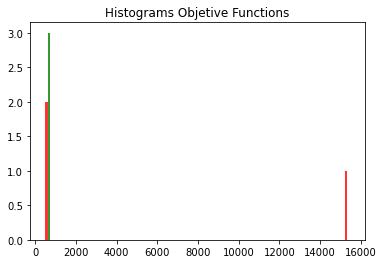

In [25]:
#%%
# Comparison of data mismatch objective function
# prior (l = 0)
CeInv = np.power(CeDiag, -1)
OPrior = calcDataMismatchObjectiveFunction(dObs[:,np.newaxis], DPrior, CeInv)
OPost = calcDataMismatchObjectiveFunction(dObs[:,np.newaxis], DPost, CeInv)

print(f'Mean: prior={np.mean(OPrior):.3e}, post={np.mean(OPost):.3e}')
print(f'Std: prior={np.std(OPrior, ddof=1):.3e}, post={np.std(OPost, ddof=1):.3e}')

fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((OPrior, OPost), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Objetive Functions')

Mean: prior=3.043e+01, post=4.700e+01
Std: prior=1.973e+01, post=4.604e-02


Text(0.5, 1.0, 'Histograms angles before and after history matching')

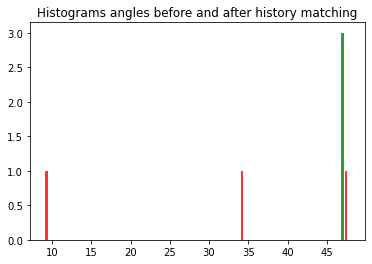

In [30]:
#Compare  the histograms of frac_aper prior and post

print(f'Mean: prior={np.mean(MScalarPrior):.3e}, post={np.mean(MScalarPost):.3e}')
print(f'Std: prior={np.std(MScalarPrior, ddof=1):.3e}, post={np.std(MScalarPost, ddof=1):.3e}')


fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((MScalarPrior, MScalarPost), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms angles before and after history matching')



IndexError: list index out of range

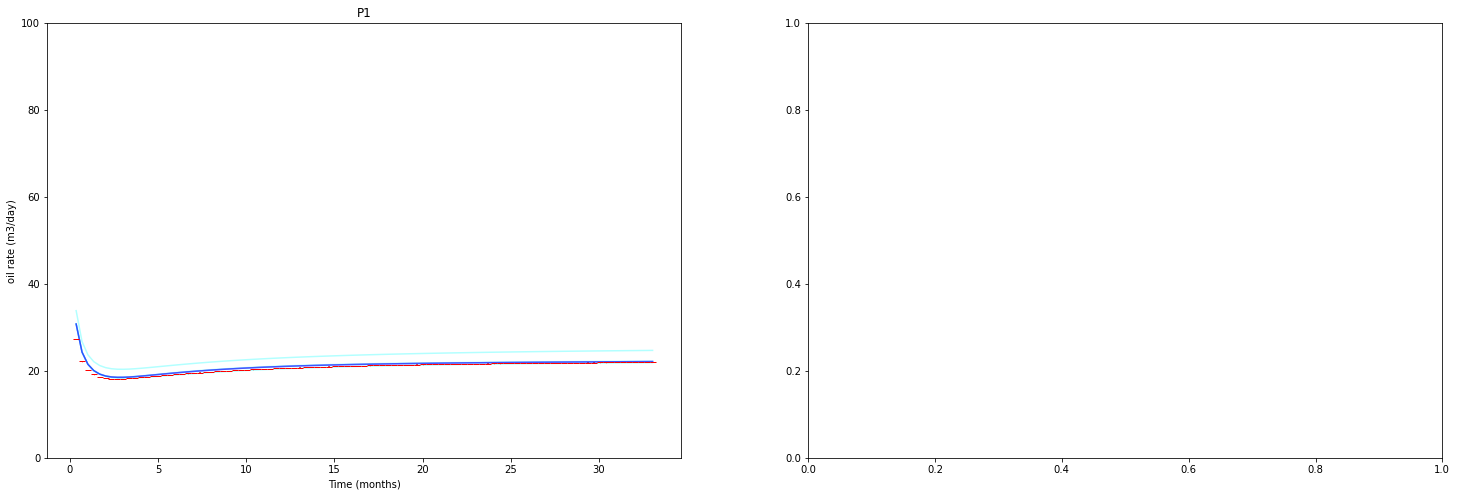

In [29]:
#%%
# Split the data into data array
wellDataPriorArray = np.split(DPrior, NWells)
wellDataPostArray = np.split(DPost, NWells)
wellDataObsArray = np.split(dObs, NWells)
wellDataObsErrorArray = np.split(CeDiag, NWells)

wellSubtitle = ['P1']
timeMonths = time_range[1:]/30.0


# get data and store in an array
prior = wellDataPriorArray # wellDataPriorArray[0:11:2]
post = wellDataPostArray # wellDataPostArray[0:11:2]
plotObsData = wellDataObsArray #wellDataObsArray[0:11:2]
errObsData = wellDataObsErrorArray #wellDataObsErrorArray[0:11:2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
axFlat = ax.flatten()

axFlat[0].set_facecolor('white')
axFlat[0].plot(timeMonths, prior[0], color='#00FFFF', alpha=0.3)
axFlat[0].plot(timeMonths, post[0], color='b', alpha=0.3)
axFlat[0].errorbar(timeMonths, plotObsData[0], yerr=errObsData[0], fmt='_ r', capthick=1, capsize=0.1)
#axFlat[0].plot(timeMonths, plotObsData[i],color='red', alpha=0.5)
axFlat[0].set_title(wellSubtitle[0])
axFlat[0].set_xlabel('Time (months)')
axFlat[0].set_ylabel('oil rate (m3/day)')
axFlat[0].set_ylim([0, 100])


axFlat[1].plot(timeMonths, prior[1], color='#00FFFF', alpha=0.3)
axFlat[1].plot(timeMonths, post[1], color='b', alpha=0.3)
axFlat[1].scatter(timeMonths, plotObsData[1],color='red', alpha=0.5)
axFlat[1].set_title(wellSubtitle[0])
axFlat[1].set_xlabel('Time (months)')
axFlat[1].set_ylabel('oil rate (m3/day)')
#axFlat[1].set_ylim([342, 348])
fig.suptitle('P1 : oil rate (m3/day)')


In [1]:
!jupyter nbconvert --to html mainDA_explained.ipynb

[NbConvertApp] Converting notebook mainDA_explained.ipynb to html
[NbConvertApp] Writing 701465 bytes to mainDA_explained.html


Evaluating the Water Rate Results

In [155]:
vazao = ['P1 : water rate (m3/day)']
#Read the result of the posterior
D_qw = ReadModels(destDir, vazao, Nd, Ne)*(-1)
#Read the result of the prior
Prior = 20
D_qw_prior = ReadModels('simulations\it0', vazao, Nd, Prior)*(-1)

#Read the reference data 
obsData_qw= np.array(time_data['P1 : water rate (m3/day)'])
obsValues_qw = np.array(obsData_qw)*(-1)
dObs_qw = obsValues_qw.T.flatten()
CeDiag_qw =np.array(0.001*dObs_qw[:]) #diagonal of the covariance matrix of observed data %1 of the water rate



Text(0.5, 0.98, 'P1 : water rate (m3/day)')

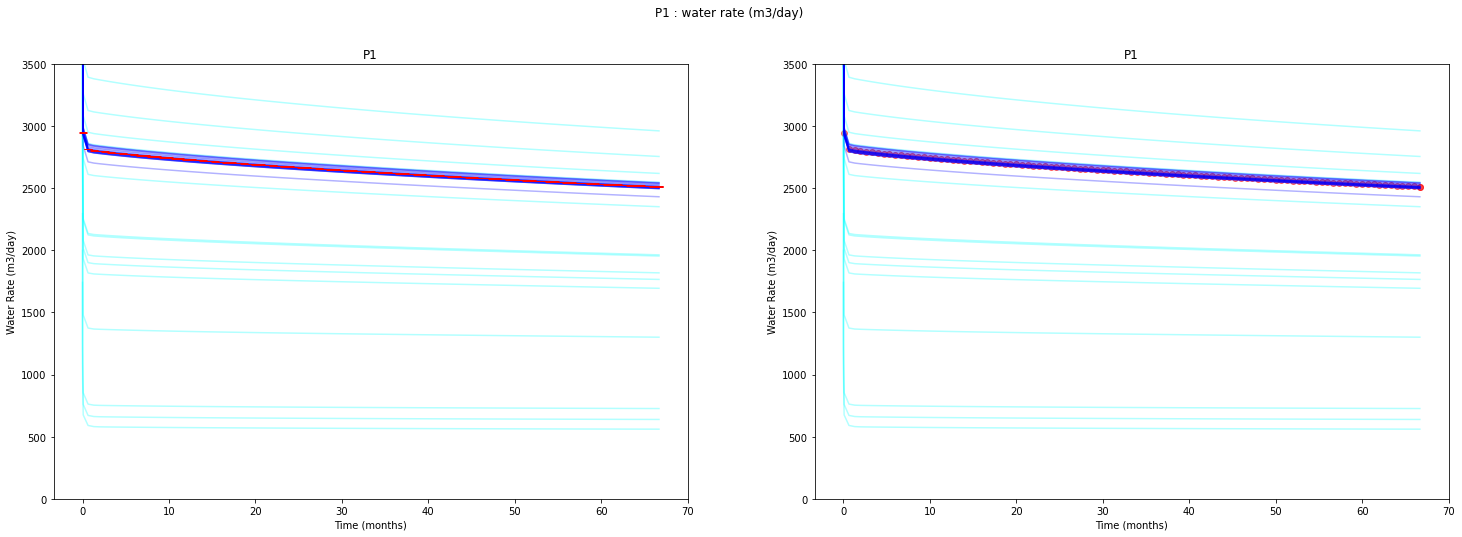

In [162]:
#%%
# Split the data into data array
wellDataPriorArray = np.split(D_qw_prior, NWells)
wellDataPostArray = np.split(D_qw, NWells)
wellDataObsArray = np.split(dObs_qw, NWells)
wellDataObsErrorArray = np.split(CeDiag_qw, NWells)

wellSubtitle = ['P1']
timeMonths = dTime/30.0


# get data and store in an array
prior = wellDataPriorArray # wellDataPriorArray[0:11:2]
post = wellDataPostArray # wellDataPostArray[0:11:2]
plotObsData = wellDataObsArray #wellDataObsArray[0:11:2]
errObsData = wellDataObsErrorArray #wellDataObsErrorArray[0:11:2]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
axFlat = ax.flatten()

axFlat[0].set_facecolor('white')
axFlat[0].plot(timeMonths, prior[0], color='#00FFFF', alpha=0.3)
axFlat[0].plot(timeMonths, post[0], color='b', alpha=0.3)
axFlat[0].errorbar(timeMonths, plotObsData[0], yerr=errObsData[i], fmt='_ r', capthick=1, capsize=4)
#axFlat[0].plot(timeMonths, plotObsData[i],color='red', alpha=0.5)
axFlat[0].set_title(wellSubtitle[0])
axFlat[0].set_xlabel('Time (months)')
axFlat[0].set_ylabel('Water Rate (m3/day)')
axFlat[0].set_ylim([0, 3500])

axFlat[1].plot(timeMonths, prior[0], color='#00FFFF', alpha=0.3)
axFlat[1].plot(timeMonths, post[0], color='b', alpha=0.3)
axFlat[1].scatter(timeMonths, plotObsData[0],color='red', alpha=0.5)
axFlat[1].set_title(wellSubtitle[0])
axFlat[1].set_xlabel('Time (months)')
axFlat[1].set_ylabel('Water Rate (m3/day)')
axFlat[1].set_ylim([0, 3500])
fig.suptitle('P1 : water rate (m3/day)')



Mean: prior=8.654e+07, post=1.637e+04
Std: prior=1.268e+08, post=4.385e+04


Text(0.5, 1.0, 'Histograms Objetive Functions for water rate')

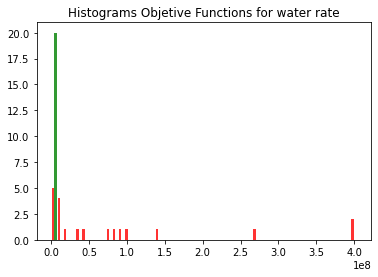

In [164]:
#%%
# Comparison of data mismatch objective function
CeInv_qw = np.power(CeDiag_qw, -1)
OPrior_qw = calcDataMismatchObjectiveFunction(dObs_qw[:,np.newaxis],D_qw_prior, CeInv_qw)
OPost_qw = calcDataMismatchObjectiveFunction(dObs_qw[:,np.newaxis],D_qw, CeInv_qw)
print(f'Mean: prior={np.mean(OPrior_qw):.3e}, post={np.mean(OPost_qw):.3e}')
print(f'Std: prior={np.std(OPrior_qw, ddof=1):.3e}, post={np.std(OPost_qw, ddof=1):.3e}')

fig, ax = plt.subplots()#plt.subplots(figsize=(Ne,Ne))
colors=['red','green']
x = np.stack((OPrior_qw, OPost_qw), axis=1)
#ax.hist(x, bins=40, alpha=0.8, color=colors, range=(x.min(),1e7))
ax.hist(x, bins=50, alpha=0.8, color=colors)
ax.set_title('Histograms Objetive Functions for water rate')